In [22]:
import re
import string
from unicodedata import normalize

import matplotlib.pyplot as plt
from wordcloud import WordCloud
%matplotlib inline

import gensim
import pandas as pd
import spacy
from gensim import corpora
from gensim import models
from gensim.models import CoherenceModel
from nltk import word_tokenize
from nltk.corpus import stopwords

In [23]:
nlp = spacy.load('es_core_news_sm')

In [28]:
esp_stop = stopwords.words('spanish')
esp_stop = esp_stop
esp_stop.remove('estado')

In [29]:
def lemmatizer(text):
  doc = nlp(text)
  return ' '.join([word.lemma_ for word in doc if word.lemma_ not in esp_stop])

### Apertura archivo y preprocesamiento

In [24]:
with open("data/nc_ch_articles.txt", "r") as file:
    data = file.read()
    data = data.replace("\n", " ")
    data = re.sub("\d+", "", data)
    data = data.lower()
    list_art = data.split("--articulo--")

In [25]:
df_art = pd.DataFrame(list_art, columns = ["article"])

In [113]:
def preprocess(df, column):
  articles = df

  articles[column] = articles[column].str.translate(str.maketrans(' ', ' ', string.punctuation))
  articles[column] = articles[column].str.strip()
  articles[column] = articles[column].str.replace('\n', ' ')
  articles[column] = articles[column].str.replace('nº', ' ')
  articles[column] = articles[column].str.translate(str.maketrans(' ', ' ', string.punctuation))
  articles[column] = articles[column].apply(lambda x: " ".join(x.split()))
  articles[column] = articles[column].apply(lambda x: re.sub(r"([^n\u0300-\u036f]|n(?!\u0303(?![\u0300-\u036f])))[\u0300-\u036f]+", r"\1", normalize("NFD", x), 0, re.I))

  articles = articles[[len(str(x).split()) > 2 for x in articles[column]]]
  return articles.reset_index(drop=True)

In [92]:
df_art_p = preprocess(df_art, "article")

In [93]:
corpus = [word_tokenize(lemmatizer(i)) for i in df_art_p["article"]]

In [94]:
dict_corpus = corpora.Dictionary(corpus)

dtm_gensim = [dict_corpus.doc2bow(i) for i in corpus]
dtm_gensim_tfidf = models.TfidfModel(dtm_gensim)[dtm_gensim]

In [95]:
lda_gensim = gensim.models.ldamodel.LdaModel
ldamodel_gensim = lda_gensim(
    dtm_gensim_tfidf,
    num_topics = 25,
    passes = 1000,
    id2word = dict_corpus,
    random_state = 0,
    eval_every = None,
    alpha = 'auto'
)

In [96]:
ldamodel_gensim.print_topics(
    num_words = 15,
    num_topics = 49
)

[(0,
  '0.012*"pueblo" + 0.011*"autonoma" + 0.009*"politica" + 0.009*"educacion" + 0.009*"comuna" + 0.009*"libre" + 0.009*"region" + 0.009*"mecanismo" + 0.009*"vida" + 0.009*"medida" + 0.009*"asegurar" + 0.009*"autonomia" + 0.008*"especial" + 0.008*"reconocer" + 0.008*"necesario"'),
 (1,
  '0.003*"cambio" + 0.003*"asambleista" + 0.003*"resolutivo" + 0.002*"proporcion" + 0.002*"corriente" + 0.002*"pedagogico" + 0.002*"consecutivamente" + 0.002*"crediticia" + 0.002*"dinero" + 0.002*"educador" + 0.002*"prohibicion" + 0.002*"transversal" + 0.002*"comprension" + 0.002*"etnico" + 0.002*"reciproco"'),
 (2,
  '0.003*"tecnologia" + 0.003*"economica" + 0.003*"arma" + 0.003*"correccional" + 0.003*"superintendencia" + 0.003*"modernizacion" + 0.003*"minero" + 0.002*"maritorio" + 0.002*"obligacion" + 0.002*"utilizar" + 0.002*"usuario" + 0.002*"consumidor" + 0.002*"emprender" + 0.002*"tamaño" + 0.002*"asegurarar"'),
 (3,
  '0.006*"consejero" + 0.005*"consejera" + 0.005*"portuario" + 0.003*"multipl" 

In [97]:
df_topic_term = pd.DataFrame(
    ldamodel_gensim.get_topics(),
    columns = ldamodel_gensim.id2word.values(),
    index = [f'topic{i}' for i in range(ldamodel_gensim.num_topics)]
)

In [98]:
df_topic_term.sort_values(by = df_topic_term.columns.values.tolist(), ascending = False)

,actividad,asegurar,bien,chile,colectivo,condición,constituir,cultural,deber,democracia,...,quincuagesima,quincuagesimo,rebajar,recaer,reclamacion,reconstruccion,rever,segunir,tipificado,transitarar
topic0,0.006589,0.008541,0.000089,0.000089,0.003296,0.000089,0.000089,0.007906,0.000089,0.005194,...,0.000089,0.000089,0.000089,0.000089,0.000089,0.000089,0.000089,0.000089,0.000089,0.000089
topic10,0.000281,0.000281,0.000281,0.000281,0.000281,0.000281,0.000281,0.000281,0.000281,0.000281,...,0.000281,0.000281,0.000281,0.000281,0.000281,0.000281,0.000281,0.000281,0.000281,0.000281
topic4,0.000279,0.000279,0.000279,0.000279,0.000279,0.000279,0.000279,0.000279,0.000279,0.000279,...,0.000279,0.000279,0.000279,0.000279,0.000279,0.000279,0.000279,0.000279,0.000279,0.000279
topic3,0.000275,0.000275,0.000275,0.000275,0.000275,0.000275,0.000275,0.000275,0.000275,0.000275,...,0.000275,0.000275,0.000275,0.000275,0.000275,0.000275,0.000275,0.000275,0.000275,0.000275
topic14,0.000270,0.000270,0.000270,0.000270,0.000270,0.000270,0.000270,0.000270,0.000270,0.000270,...,0.000270,0.000270,0.000270,0.000270,0.000270,0.000270,0.000270,0.000270,0.000270,0.000270
topic1,0.000270,0.000270,0.000270,0.000270,0.000270,0.000270,0.000270,0.000270,0.000270,0.000270,...,0.000270,0.000270,0.000270,0.000270,0.000270,0.000270,0.000270,0.000270,0.000270,0.000270
topic22,0.000266,0.000266,0.000266,0.000266,0.000266,0.000266,0.000266,0.000266,0.000266,0.000266,...,0.000266,0.000266,0.000266,0.000266,0.000266,0.000266,0.000266,0.000266,0.000266,0.000266
topic16,0.000263,0.000263,0.000263,0.000263,0.000263,0.000263,0.000263,0.000263,0.000263,0.000263,...,0.000263,0.000263,0.000263,0.000263,0.000263,0.000263,0.000263,0.000263,0.000263,0.000263
topic24,0.000261,0.000261,0.000261,0.000261,0.000261,0.000261,0.000261,0.000261,0.000261,0.000261,...,0.000261,0.000261,0.000261,0.000261,0.000261,0.000261,0.000261,0.000261,0.000261,0.000261
topic2,0.000261,0.000261,0.000261,0.000261,0.000261,0.000261,0.000261,0.000261,0.000261,0.000261,...,0.000261,0.000261,0.000261,0.000261,0.000261,0.000261,0.000261,0.000261,0.000261,0.000261


In [99]:
# Compute Coherence Score
'''
La Métrica de Coherencia nos da una idea de cómo de coherente es un modelo en cuanto a la distribución de sus topics: cuanto más distintas sean las palabras de los topics entre sí, menos relacionados estarán los topics y más coherente será el modelo.
'''
coherence_model_lda = CoherenceModel(model=ldamodel_gensim, texts=corpus, dictionary=dict_corpus, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)

# Compute Perplexity
'''
Por otro lado, la Perplejidad es una medida de cuánto se sorprende el modelo cuando se le añade datos que no había visto antes.
'''
print('\nPerplexity: ', ldamodel_gensim.log_perplexity(dtm_gensim_tfidf))  # a measure of how good the model is. lower the better.


Coherence Score:  0.46405352251097526

Perplexity:  -11.995597933699742


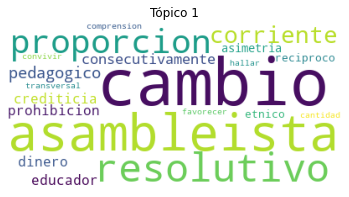

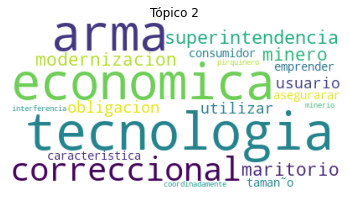

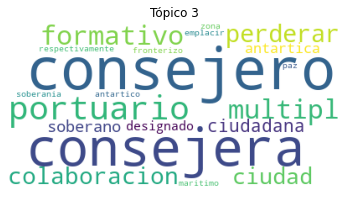

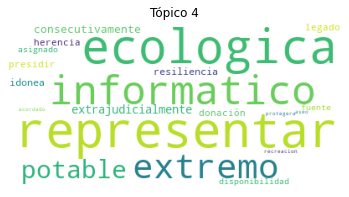

In [100]:
for i in range(1, 5):
    plt.figure()
    plt.imshow(
        WordCloud(
            background_color = 'white',
            prefer_horizontal = 1.0
        ).fit_words(dict(ldamodel_gensim.show_topic(i, 20)))
    )
    plt.axis("off")
    plt.title("Tópico " + str(i))
    plt.show()

In [116]:
with open("data/nc_ch_chapters.txt", "r") as file:
    data = file.read()
    data = data.replace("\n", " ")
    data = re.sub("\d+", "", data)
    data = data.lower()
    list_chapters = data.split("--capitulo--")

In [117]:
df_charperts = pd.DataFrame(list_chapters, columns=["chapter"])

In [118]:
df_charperts_p = preprocess(df_charperts, "chapter")

In [119]:
corpus = [word_tokenize(lemmatizer(i)) for i in df_charperts_p["chapter"]]

In [120]:
dict_corpus = corpora.Dictionary(corpus)

dtm_gensim = [dict_corpus.doc2bow(i) for i in corpus]
dtm_gensim_tfidf = models.TfidfModel(dtm_gensim)[dtm_gensim]


In [121]:
lda_gensim = gensim.models.ldamodel.LdaModel
ldamodel_gensim = lda_gensim(
    dtm_gensim_tfidf,
    num_topics=8,
    passes=1000,
    id2word=dict_corpus,
    random_state=0,
    eval_every=None,
    alpha='auto'
)

In [122]:
ldamodel_gensim.print_topics(
    num_words=15,
    num_topics=8
)

[(0,
  '0.000*"correcta" + 0.000*"correspondencia" + 0.000*"conferida" + 0.000*"consagra" + 0.000*"consecutivamente" + 0.000*"contraloria" + 0.000*"contrato" + 0.000*"convenio" + 0.000*"convocar" + 0.000*"convocatoria" + 0.000*"coordinadamente" + 0.000*"correccion" + 0.000*"concretar" + 0.000*"delimitacion" + 0.000*"demandar"'),
 (1,
  '0.001*"dignidad" + 0.001*"corrupcion" + 0.001*"portuario" + 0.001*"reconocimiento" + 0.001*"reconocer" + 0.001*"emblema" + 0.001*"rendicion" + 0.001*"tributario" + 0.001*"buen" + 0.001*"vida" + 0.001*"pueblo" + 0.001*"eficiente" + 0.001*"economia" + 0.001*"pertinencia" + 0.001*"capacitacion"'),
 (2,
  '0.000*"correcta" + 0.000*"correspondencia" + 0.000*"conferida" + 0.000*"consagra" + 0.000*"consecutivamente" + 0.000*"contraloria" + 0.000*"contrato" + 0.000*"convenio" + 0.000*"convocar" + 0.000*"convocatoria" + 0.000*"coordinadamente" + 0.000*"correccion" + 0.000*"concretar" + 0.000*"delimitacion" + 0.000*"demandar"'),
 (3,
  '0.001*"presidenta" + 0.001

In [123]:
df_topic_term = pd.DataFrame(
    ldamodel_gensim.get_topics(),
    columns=ldamodel_gensim.id2word.values(),
    index=[f'topic{i}' for i in range(ldamodel_gensim.num_topics)]
)

df_topic_term.sort_values(by=df_topic_term.columns.values.tolist(), ascending=False)

,acceso,accion,actividad,acto,actuan,actuar,adecuado,adecuar,administracion,adoptar,...,undecimo,usted,veinticinco,vencer,versen,vista,¿,“,”,…
topic5,0.000443,0.000457,0.000326,0.000274,0.000266,0.000271,0.000316,0.000266,0.000266,0.000317,...,0.000266,0.000266,0.000266,0.000266,0.000266,0.000266,0.000266,0.000266,0.000266,0.000266
topic1,0.000346,0.000325,0.000352,0.000281,0.000443,0.000346,0.000307,0.000428,0.000272,0.000307,...,0.000272,0.000272,0.000272,0.000272,0.000272,0.000272,0.000272,0.000272,0.000272,0.000272
topic4,0.000308,0.000304,0.000298,0.000289,0.000281,0.000294,0.000310,0.000281,0.000281,0.000305,...,0.000281,0.000281,0.000281,0.000281,0.000281,0.000281,0.000281,0.000281,0.000281,0.000281
topic7,0.000296,0.000423,0.000294,0.000283,0.000269,0.000277,0.000287,0.000269,0.000269,0.000297,...,0.000269,0.000269,0.000269,0.000269,0.000269,0.000269,0.000269,0.000269,0.000269,0.000269
topic0,0.000292,0.000292,0.000292,0.000292,0.000292,0.000292,0.000292,0.000292,0.000292,0.000292,...,0.000292,0.000292,0.000292,0.000292,0.000292,0.000292,0.000292,0.000292,0.000292,0.000292
topic2,0.000292,0.000292,0.000292,0.000292,0.000292,0.000292,0.000292,0.000292,0.000292,0.000292,...,0.000292,0.000292,0.000292,0.000292,0.000292,0.000292,0.000292,0.000292,0.000292,0.000292
topic6,0.000292,0.000292,0.000292,0.000292,0.000292,0.000292,0.000292,0.000292,0.000292,0.000292,...,0.000292,0.000292,0.000292,0.000292,0.000292,0.000292,0.000292,0.000292,0.000292,0.000292
topic3,0.000256,0.000251,0.000274,0.000278,0.000251,0.000273,0.000274,0.000417,0.000251,0.000273,...,0.000279,0.000310,0.000279,0.000279,0.000279,0.000279,0.000310,0.000373,0.000373,0.000279


In [124]:
# Compute Coherence Score
'''
La Métrica de Coherencia nos da una idea de cómo de coherente es un modelo en cuanto a la distribución de sus topics: cuanto más distintas sean las palabras de los topics entre sí, menos relacionados estarán los topics y más coherente será el modelo.
'''
coherence_model_lda = CoherenceModel(model=ldamodel_gensim, texts=corpus, dictionary=dict_corpus, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)

# Compute Perplexity
'''
Por otro lado, la Perplejidad es una medida de cuánto se sorprende el modelo cuando se le añade datos que no había visto antes.
'''
print('\nPerplexity: ', ldamodel_gensim.log_perplexity(dtm_gensim_tfidf))  # a measure of how good the model is. lower the better.


Coherence Score:  0.5022070558045553

Perplexity:  -13.176718313430271


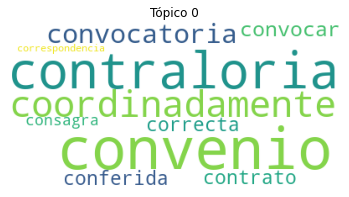

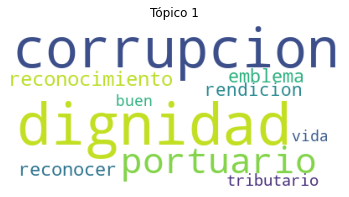

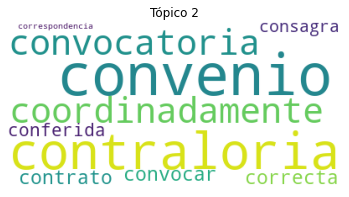

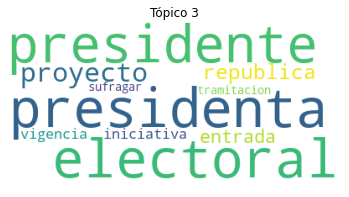

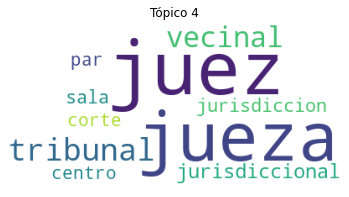

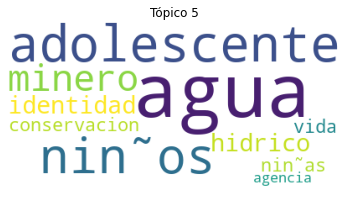

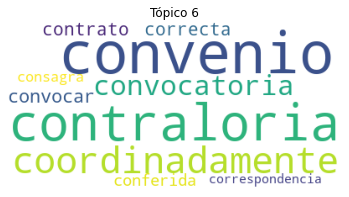

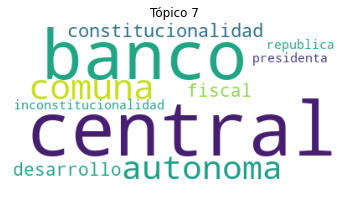

In [129]:
for i in range(0, 8):
    plt.figure()
    plt.imshow(
        WordCloud(
            background_color = 'white',
            prefer_horizontal = 1.0
        ).fit_words(dict(ldamodel_gensim.show_topic(i, 10)))
    )
    plt.axis("off")
    plt.title("Tópico " + str(i))
    plt.show()